# Eigentechno 8820 Hz Equalized

In [1]:
import array, math, time, argparse, sys
import scipy.io.wavfile as wav
import scipy
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import json
import h5py

proc_srate = 8820
srate = proc_srate

# string used to identify outputs
iden_str = "8820_full_eqd"

In [23]:
# as usual, ith bin has the amplitude of freq i * srate/slen
def freq_scale2(i, srate=proc_srate, slen=slen):
    if i > slen // 2:
        return freq_scale2(slen - 1 - i, srate=proc_srate, slen=slen)
    freq = i * srate / slen
    low_start = 50
    high_end = 0.5 * srate / 2 
    slope = 0.454 
    c = 0.12
    a = 0
    b = np.log10(high_end/50)
    g = lambda x: 1 - slope * x + c*(x - a)*(x - b)
    if freq < low_start:
        toret = 1.0
    elif freq < high_end:
        toret = g(np.log10(freq / 50))
    else:
        toret = g(np.log10(high_end / 50))
    return  10 ** (- ( 35.3 - (toret*35.3)) / 20)

def equalized(X, fscale=freq_scale2):
    ftX = scipy.fft(X)
    for i, x in enumerate(ftX):
        ftX[i] = ftX[i] / fscale(i, slen=X.shape[0])
    return scipy.ifft(ftX).astype(np.float16)

def deequalized(X, fscale=freq_scale2):
    ftX = scipy.fft(X)
    for i, x in enumerate(ftX):
        ftX[i] = ftX[i] * fscale(i, slen=X.shape[0])
    return scipy.ifft(ftX).astype(np.float16)

In [24]:
# useful functions:

def read_wav_mono(filename, target_srate=44100):
    fs, samps = wav.read(filename)
    #print(samps.shape, len(samps.shape))
    if len(samps.shape) > 1:
        samps = np.apply_along_axis(np.sum, 1, samps) / 2, fs
        
    if target_srate == 22050:
        return np.delete(samps, range(1, samps.shape[0], 2)), 22050
    if target_srate == 14700:
        return np.delete(samps, [i for i in range(samps.shape[0]) if i % 3 != 0]), 14700
    if target_srate == 8820:
        return np.delete(samps, [i for i in range(samps.shape[0]) if i % 5 != 0]), 8820

    return samps, fs

def normalize(arr):
    arr[:] = arr[:] / np.max(np.abs(arr))

scale_coeff = (2**15-1)
def write_wav(arr, fs, fnm, normalized=True):
    wav.write(fnm, fs, np.asarray(scale_coeff *
        arr / (np.max(np.abs(arr)) if normalized else 1.0), dtype=np.int16))
    
def make_dir(dirname):
    dirs = dirname.split("/")
    newdir = dirs[-1]
    if newdir in os.listdir("./" + "/".join(dirs[:-1])):
        print("existing dir", dirname)
        return
    print("creating", dirname)
    os.mkdir("./" + dirname)

In [3]:
# proc_srate = 8820
h5f = h5py.File("../dataset/8820_full_eqd_dataset.h5",'r')
XX = h5f['loops'][:]
mean_wave = h5f['mean'][:]
h5f.close()
N = XX.shape[0]
slen = XX.shape[1]

In [4]:
def loop(n, X):
    return np.concatenate([X for i in range(n)], axis=0)

folder = "output/" + iden_str
make_dir(folder)
write_wav(mean_wave, srate, folder + "/" + iden_str + "_mean.wav")
write_wav(loop(4,mean_wave), srate, folder + "/" + iden_str + "_mean_looped.wav")
write_wav(loop(4,mean_wave), srate, folder + "/" + iden_str + "_mean__not_normalized_looped.wav", normalized=False)
write_wav(mean_wave, srate, folder + "/" + iden_str + "_mean__not_normalized.wav", normalized=False)

creating output/8820_full_eqd


In [5]:
folder = "output/" + iden_str + "/original"
make_dir(folder)

savelist = [175, 1060, 1360, 1420, 2650, 2930, 60947, 60980]

for i in savelist:
    write_wav(XX[i,:] + mean_wave, srate, folder + "/" + str(i) + ".wav")

creating output/8820_full_eqd/original


## Applying PCA

In [8]:
U, s, Vt = scipy.linalg.svd(XX, full_matrices=False)

In [9]:
del XX

In [10]:
W = U.dot(np.diag(s))

In [11]:
def save_svd_output(fnm, W, s, Vt, folder="saved_params"):
    make_dir(folder)
    h5f = h5py.File(folder + "/" + fnm + ".h5", "w")
    h5f.create_dataset('W', data=U)
    h5f.create_dataset('s', data=s)
    h5f.create_dataset('Vt', data=Vt)
    h5f.close()
    
save_svd_output(iden_str + "svd_out", W, s, Vt)

existing dir saved_params


In [17]:
# save some eigenvectors
folder = "output/" + iden_str + "/eigenvectors"
make_dir(folder)
for i in range(400):
    write_wav(Vt[i,:], srate, folder + "/" + str(i) + ".wav")

creating output/8820_full_eqd/eigenvectors


## Loading previously saved SVD output

In [6]:
# previously saved U as W by mistake, so loading U and computing W again
h5f = h5py.File("saved_params/eqd_2_fullsvd_8820_full.h5",'r')
U = h5f["W"][:]
s = h5f["s"][:]
Vt = h5f["Vt"][:]
h5f.close()

In [14]:
W = U.dot(np.diag(s))

In [18]:
# save some eigenvectors
folder = "output/" + iden_str + "/eigenvectors"
make_dir(folder)
for i in range(400):
    write_wav(Vt[i,:], srate, folder + "/" + str(i) + ".wav")

existing dir output/8820_full_eqd/eigenvectors


In [27]:
# save deequalized eigenvectors
folder = "output/" + iden_str + "/eigenvectors_deq"
make_dir(folder)
for i in range(100):
    print(i, end=" ")
    write_wav(deequalized(Vt[i,:]), srate, folder + "/" + str(i) + ".wav")

existing dir output/8820_full_eqd/eigenvectors_deq
0 

/home/umutisik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

## Analyzing the Eigenvectors

In [15]:
norm = np.vectorize(lambda z: np.sqrt(z.real*z.real + z.imag*z.imag))

def fft_avg(X, win_size=2048):
    fftscale = 1 #1 / win_size
    slen = X.shape[0]
    avg = np.zeros(win_size)
    count = 1
    for start in range(0, slen - win_size + 1, win_size//4):
        normfft = norm(scipy.fft(X[start:start+win_size])) * fftscale
        avg = avg + normfft #* normfft
        count += 1
    count -= 1
    avg = avg / count       
    #print(np.max(avg))
    return avg

def spectrum_plot(spectrum, srate, show=True, title="", averaging=0, alpha=0.8):
    slen = spectrum.shape[0]
    S = 20 * np.log10(spectrum[:slen//2])
    newS = np.zeros(S.shape)
    if averaging > 0:
        for i in range(1,S.shape[0]):
            width = round((np.log10(i * srate / slen))**averaging)
            width = 0 if width < 0 else int(width)
            left_end = 0 if i - width < 0 else i - width
            right_end = slen if i + width + 1 > slen else i + width + 1
            newS[i] = np.mean(S[left_end : right_end])
    else:
        newS = S
    plt.plot(np.linspace(0,srate/2,slen//2), newS, alpha=alpha)
    plt.xscale('log')
    #plt.title(title)
    
    if show:
        plt.show()

creating output/8820_full_eqd/eigenvectorFFT


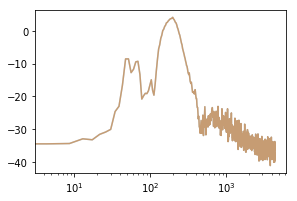

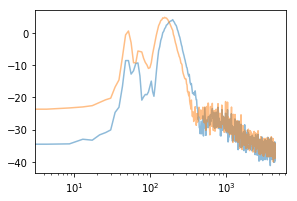

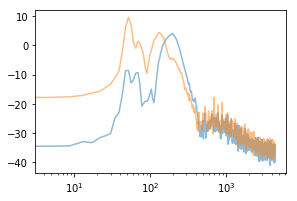

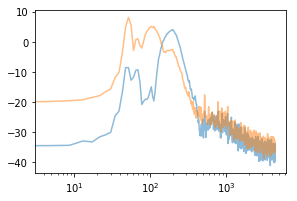

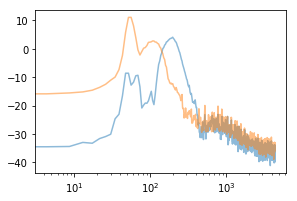

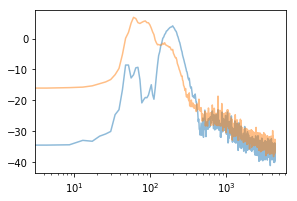

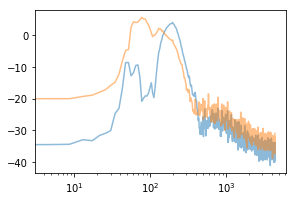

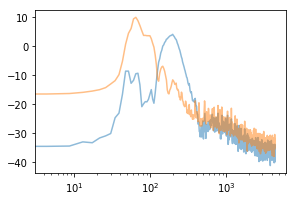

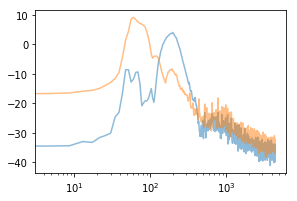

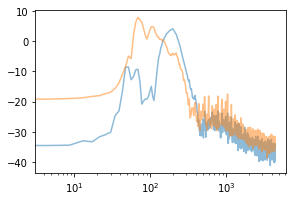

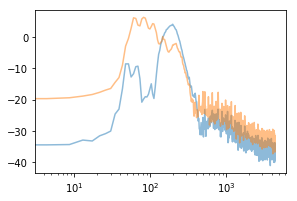

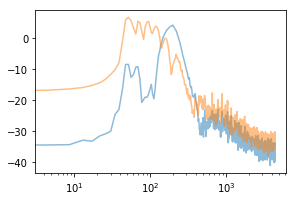

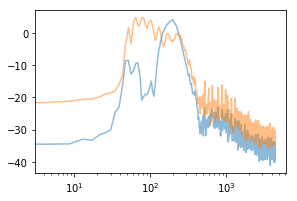

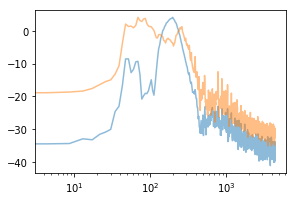

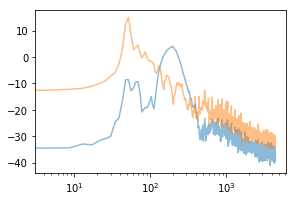

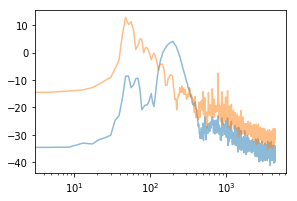

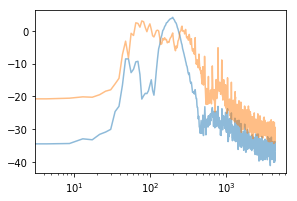

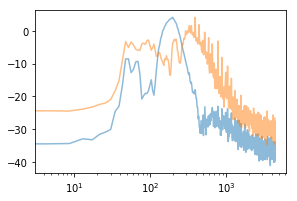

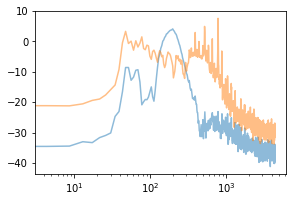

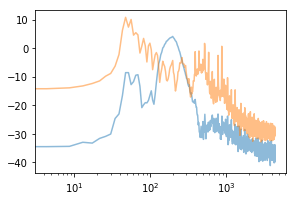

In [16]:
nn = 20
folder = "output/" + iden_str + "/eigenvectorFFT"
make_dir(folder)

for i in range(nn):
    plt.figure(figsize=(4.5,3))
    spectrum_plot(fft_avg(Vt[0]), proc_srate, show=False, title=str(i), averaging=0, alpha=0.5)
    spectrum_plot(fft_avg(Vt[i]), proc_srate, show=False, title=str(i), averaging=0, alpha=0.5)
    plt.savefig(folder + "/" + str(i), dpi=200, transparent=True)
    plt.show() 
    

creating output/8820_full_eqd/eigenvectorFFT_deq


/home/umutisik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


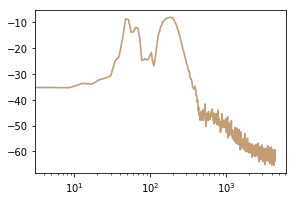

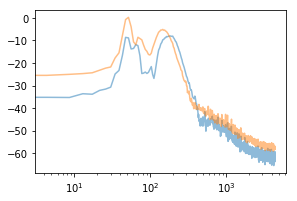

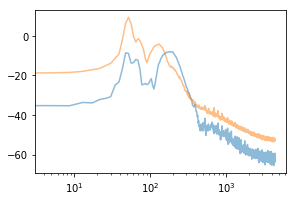

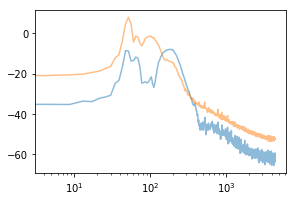

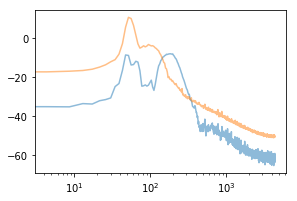

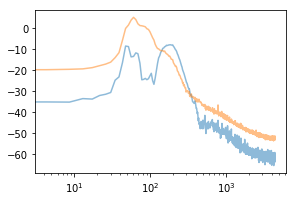

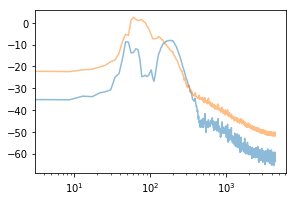

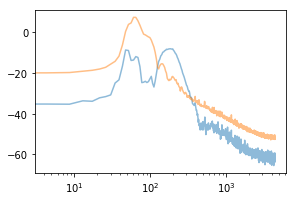

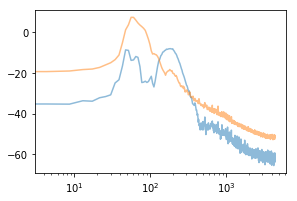

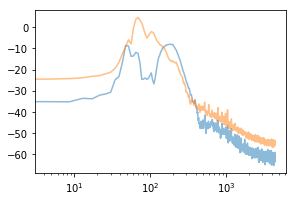

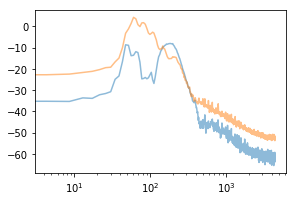

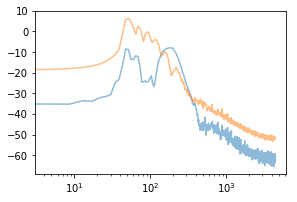

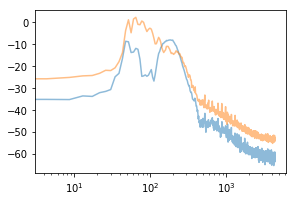

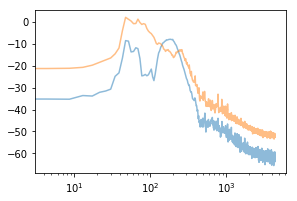

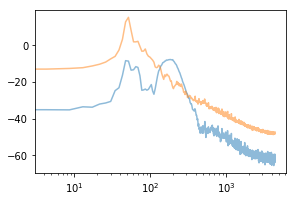

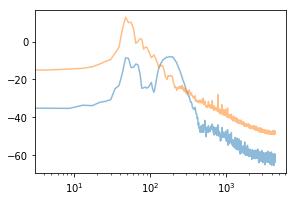

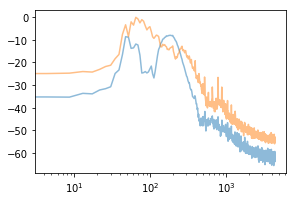

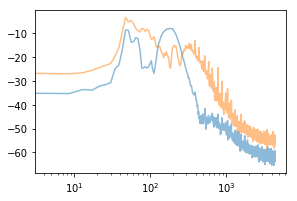

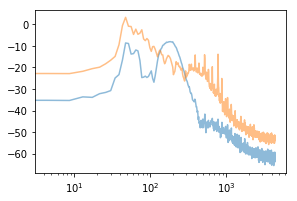

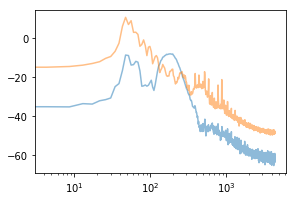

In [28]:
nn = 20
folder = "output/" + iden_str + "/eigenvectorFFT_deq"
make_dir(folder)

f0 = fft_avg(deequalized(Vt[0]))
for i in range(nn):
    plt.figure(figsize=(4.5,3))
    spectrum_plot(f0, proc_srate, show=False, title=str(i), averaging=0, alpha=0.5)
    spectrum_plot(fft_avg(deequalized(Vt[i])), proc_srate, show=False, title=str(i), averaging=0, alpha=0.5)
    plt.savefig(folder + "/" + str(i), dpi=200, transparent=True)
    plt.show() 
    

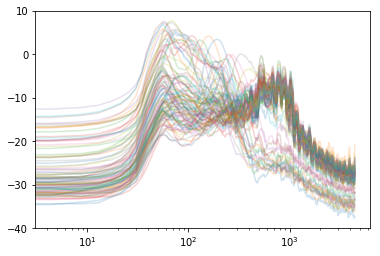

In [32]:
nn = 100
for i in range(nn):
    spectrum_plot(fft_avg(Vt[i]), proc_srate, show=False, title=str(i), averaging=2, alpha=0.2)
plt.savefig("output/" + iden_str + "/" + "first100eigens", dpi=300, transparent=True)
plt.show() 

/home/umutisik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


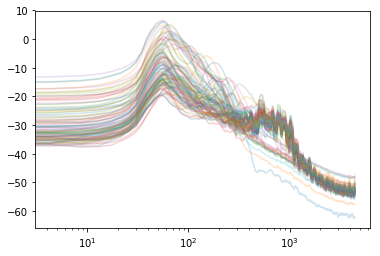

In [31]:
nn = 100
for i in range(nn):
    spectrum_plot(fft_avg(deequalized(Vt[i])), proc_srate, show=False, title=str(i), averaging=2, alpha=0.2)
plt.savefig("output/" + iden_str + "/" + "first100eigens_deq", dpi=300, transparent=True)
plt.show() 

## Singular values

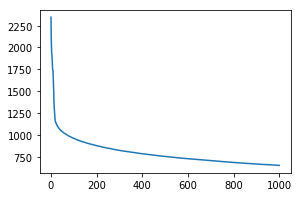

In [33]:
nn = 1000
plt.figure(figsize=(4.5,3))
plt.plot(range(nn),s[:nn])
plt.savefig("output/" + iden_str + "/singular_values", dpi=200, transparent=True)
plt.show()

# Approximations

In [34]:
# We computed the coefficients above by
# W = U.dot(np.diag(s))

In [35]:
# songs to be apprximated
savelist

[175, 1060, 1360, 1420, 2650, 2930, 60947, 60980]

In [36]:
numlist = [1, 33, 82, 330, 826, 3307, 8269, 16537] # out of 16538 eigenvectors
approxes = [W[savelist,:k].dot(Vt[:k,:]) for k in numlist] 

In [37]:
dir_name = "output/" + iden_str + "/approxes"
make_dir(dir_name)
for in_sav, i in enumerate(savelist):
    for in_num, num_eigens in enumerate(numlist):
        write_wav(approxes[in_num][in_sav], srate, dir_name + "/" + str(i) + "_" + str(num_eigens) + ".wav")

creating output/8820_full_eqd/approxes


In [ ]:
dir_name = "output/" + iden_str + "/approxes_deq"
make_dir(dir_name)
for in_sav, i in enumerate(savelist):
    for in_num, num_eigens in enumerate(numlist):
        write_wav(deequalized(approxes[in_num][in_sav]), srate, dir_name + "/" + str(i) + "_" + str(num_eigens) + ".wav")

Let's add the mean back too:

In [40]:
approxes_with_mean = approxes + mean_wave

In [41]:
dir_name = "output/" + iden_str + "/approxes"
make_dir(dir_name)
for in_sav, i in enumerate(savelist):
    for in_num, num_eigens in enumerate(numlist):
        write_wav(approxes_with_mean[in_num][in_sav], srate, dir_name + "/withmean_" + str(i) + "_" + str(num_eigens) + ".wav")

existing dir output/8820_full_eqd/approxes


In [42]:
dir_name = "output/" + iden_str + "/approxes_deq"
make_dir(dir_name)
for in_sav, i in enumerate(savelist):
    for in_num, num_eigens in enumerate(numlist):
        print(".", end="")
        write_wav(deequalized(approxes_with_mean[in_num][in_sav]), srate, dir_name + "/withmean_" + str(i) + "_" + str(num_eigens) + ".wav")

existing dir output/8820_full_eqd/approxes_deq
.

/home/umutisik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


...............................................................

## Transition from 1 to all eigenvectors being used to approximate

In [43]:
def awesome_loop(n):
    print("starting loop:", n)
    X = XX[n]

    num_loops = 32
    num_approxes = Vt.shape[0]
    approxes_per_loop = 4
    start_locs = [i * (slen // approxes_per_loop) for i in range(approxes_per_loop)] + [slen]
    approx_select = lambda a: int(round(a*a*1.1333))
    fin_loop = np.zeros(num_loops * slen, dtype=np.float16)
    Xd = deequalized(X + mean_wave)
    
    # counting over approx no
    for count in range(num_loops * approxes_per_loop):
        if count % approxes_per_loop == 0:
            print(count // approxes_per_loop, end=" ")
        k = approx_select(count)
        if k < num_approxes:
            approx = deequalized(W[n,:k].dot(Vt[:k,:]) + mean_wave)
        else:
            approx = Xd
        T = approx
        start = start_locs[count % approxes_per_loop]
        end = start_locs[(count % approxes_per_loop) + 1]
        fin_loop[ slen * (count // approxes_per_loop) + start : slen * (count // approxes_per_loop) + end ] = T[start:end]

    #fin_loop = np.concatenate([fin_loop, loop(8, Xd)], axis=0)
    return fin_loop

#savelist2 = [1420]
dir_name = "output/" + iden_str + "/approxes_deq"
make_dir(dir_name)
for sav in savelist:
    X = awesome_loop(sav)
    write_wav(X, srate, dir_name + "/" + str(sav) + "_twm.wav")


existing dir output/8820_full_eqd/approxes_deq
starting loop: 175


/home/umutisik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 1060
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 1360
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 1420
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 2650
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 2930
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 60947
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 60980
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 